# Подготовка датасета

## Загрузка данных

### https://www.kaggle.com/mikhailklemin/kinopoisks-movies-reviews 

In [1]:
import json
import pandas as pd
import os

In [2]:
def read_files(path):
    result = []
    files = os.listdir(path)
    for f in files:
        with open (f'{path}/{f}', "r", encoding="utf-8") as file:
            data = file.read().replace('\n', '')
            result.append(data)
    
    return result

negative_reviews = read_files('kinopoisk/neg')
neutral_reviews = read_files('kinopoisk/neu')
positive_reviews = read_files('kinopoisk/pos')

negative_reviews_df = pd.DataFrame(data={'text': negative_reviews, 'sentiment': -1})
neutral_reviews_df = pd.DataFrame(data={'text': neutral_reviews, 'sentiment': 0})
positive_reviews_df = pd.DataFrame(data={'text': positive_reviews, 'sentiment': 1})

reviews_df = negative_reviews_df.append(neutral_reviews_df).append(positive_reviews_df)

In [3]:
reviews_df['sentiment'].unique()

array([-1,  0,  1], dtype=int64)

In [4]:
reviews_df.head()

,text,sentiment
0,В 2003-ем году под руководством малоизвестного...,-1
1,"Грустно и печально. Грустно от того, что довол...",-1
2,Давным-давно Кира Найтли ворвалась на экран от...,-1
3,"Я, в общем, ничего против уравновешенного феми...",-1
4,"Измена — один из сюжетов, который всегда будет...",-1


### https://www.kaggle.com/c/sentiment-analysis-in-russian/overview

In [5]:
with open ('russian_news.json', "r", encoding="utf-8") as file:
    data = file.read().replace('\n', '')

json_data = json.loads(data)
news_df = pd.DataFrame(json_data)

def reformat_sentiment(sentiment):
    if sentiment == 'negative':
        return -1
    if sentiment == 'positive':
        return 1
    if sentiment == 'neutral':
        return 0
    
    return None

news_df['sentiment'] = news_df['sentiment'].apply(reformat_sentiment)

In [6]:
news_df['sentiment'].unique()

array([-1,  1,  0], dtype=int64)

In [7]:
news_df = news_df[['text', 'sentiment']]
news_df.head()

,text,sentiment
0,Досудебное расследование по факту покупки ЕНПФ...,-1
1,Медики рассказали о состоянии пострадавшего му...,-1
2,"Прошел почти год, как железнодорожным оператор...",-1
3,По итогам 12 месяцев 2016 года на территории р...,-1
4,Астана. 21 ноября. Kazakhstan Today - Агентств...,-1


### https://github.com/sismetanin/rureviews

In [8]:
women_clothing_df = pd.read_csv('rureviews.csv', encoding='UTF-8', sep='\t')

def reformat_sentiment_with_typo(sentiment):
    if sentiment == 'negative':
        return -1
    if sentiment == 'positive':
        return 1
    if sentiment == 'neautral':
        return 0
    
    return None

women_clothing_df['sentiment'] = women_clothing_df['sentiment'].apply(reformat_sentiment_with_typo)

In [9]:
women_clothing_df['sentiment'].unique()

array([-1,  0,  1], dtype=int64)

In [10]:
women_clothing_df.columns = ['text', 'sentiment']
women_clothing_df.head()

,text,sentiment
0,качество плохое пошив ужасный (горловина напер...,-1
1,"Товар отдали другому человеку, я не получила п...",-1
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",-1
3,"товар не пришел, продавец продлил защиту без м...",-1
4,"Кофточка голая синтетика, носить не возможно.",-1


### rusentiment

In [11]:
rusentiment_df1 = pd.read_csv('rusentiment/rusentiment_preselected_posts.csv')
rusentiment_df2 = pd.read_csv('rusentiment/rusentiment_random_posts.csv')
rusentiment_df3 = pd.read_csv('rusentiment/rusentiment_test.csv')

rusentiment_df = rusentiment_df1.append(rusentiment_df2).append(rusentiment_df3)
rusentiment_df['sentiment'] = rusentiment_df['label'].apply(reformat_sentiment)

In [12]:
rusentiment_df['sentiment'].unique()

array([ 0., -1., nan,  1.])

In [13]:
rusentiment_df = rusentiment_df[['text', 'sentiment']]
rusentiment_df.head()

,text,sentiment
0,Прорвём информационную блокаду изнутри.,0.0
1,"Никогда у меня не будет ""одного приложения для...",-1.0
2,"Кури-и тебя не укусит злая собака, потому что ...",NaN
3,"Есть 3 типа людей:\nУмные, которые делают все ...",0.0
4,мегафон чет накрыло,0.0


## Объединенный dataset

In [14]:
from functools import reduce

In [15]:
total_dfs = [reviews_df, news_df, women_clothing_df, rusentiment_df]    
total_df = reduce(lambda left, right: left.append(right), total_dfs)

total_df = total_df[total_df['sentiment'].notnull()]
total_df = total_df[total_df['text'].notnull()]

total_df.head()

,text,sentiment
0,В 2003-ем году под руководством малоизвестного...,-1.0
1,"Грустно и печально. Грустно от того, что довол...",-1.0
2,Давным-давно Кира Найтли ворвалась на экран от...,-1.0
3,"Я, в общем, ничего против уравновешенного феми...",-1.0
4,"Измена — один из сюжетов, который всегда будет...",-1.0


In [16]:
total_df.to_csv('total.csv')

# Подготовка данных

In [17]:
total_df['word_count'] = total_df['text'].apply(lambda x: len([word for word in x.split(' ')]))

## Упрощенная предобработка текста

1. Заменить знаки препинания \n на пробелы
2. Убрать заведомо "бракованные" примеры - слова с длиной более чем 35 символов (максимальная длина слова в русском языке)
3. Убрать все символы кроме русских букв
4. Убрать стоп-слова

### Дополнительная обработка (специфичная для текущего набора данных)

* Разбить рускоязычные хэштеги на слова
* Заменить смайлики на оцениваемые слова
* * Предварительно убрать парные скобки
* "Схлопнуть" дублирующиеся буквы: "отлииииииично" -> "отлично"
* Заменить очевидные оценки на оцениваемые слова: "10 из 10" -> "отличный"

### Обязательная обработка после балансировки набора данных
* Стеммизация/лемматизация

In [18]:
import numpy as np
from tqdm import tqdm
tqdm.pandas()

import re
import string

D:\SoftwareProjects\anaconda3\envs\tf-gpu\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [19]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')

russian_stopwords = stopwords.words("russian")

russian_stopwords.remove('не')
russian_stopwords.remove('нет')

russian_stopwords.sort()
print(russian_stopwords)
russian_stopwords = set(russian_stopwords)

['а', 'без', 'более', 'больше', 'будет', 'будто', 'бы', 'был', 'была', 'были', 'было', 'быть', 'в', 'вам', 'вас', 'вдруг', 'ведь', 'во', 'вот', 'впрочем', 'все', 'всегда', 'всего', 'всех', 'всю', 'вы', 'где', 'да', 'даже', 'два', 'для', 'до', 'другой', 'его', 'ее', 'ей', 'ему', 'если', 'есть', 'еще', 'ж', 'же', 'за', 'зачем', 'здесь', 'и', 'из', 'или', 'им', 'иногда', 'их', 'к', 'как', 'какая', 'какой', 'когда', 'конечно', 'кто', 'куда', 'ли', 'лучше', 'между', 'меня', 'мне', 'много', 'может', 'можно', 'мой', 'моя', 'мы', 'на', 'над', 'надо', 'наконец', 'нас', 'него', 'нее', 'ней', 'нельзя', 'ни', 'нибудь', 'никогда', 'ним', 'них', 'ничего', 'но', 'ну', 'о', 'об', 'один', 'он', 'она', 'они', 'опять', 'от', 'перед', 'по', 'под', 'после', 'потом', 'потому', 'почти', 'при', 'про', 'раз', 'разве', 'с', 'сам', 'свою', 'себе', 'себя', 'сейчас', 'со', 'совсем', 'так', 'такой', 'там', 'тебя', 'тем', 'теперь', 'то', 'тогда', 'того', 'тоже', 'только', 'том', 'тот', 'три', 'тут', 'ты', 'у', 'уж',

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dmitry\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dmitry\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [20]:
import re
import string

positive = ' радость '
negative = ' грусть '

def split_hash_tag(row):
    match = re.search(r"#([А-Яа-я]+)", row)
    if match and match.group(1):
        replacements = ' '.join(re.findall('[А-Я][^А-Я]*', match.group(1)))
        return row.replace(match.group(0), replacements)
    
    return row

def remove_parenthesis_pairs(row):
    row = re.sub(r'((\(|\[|\{)(.*)(\)|\]|\}))', '\g<2>', row)
    return row

def replace_smiles(row):    
    row = re.sub(r'((:|;|=|8)?(-|%|5|c|с)?(\)|\]|\}|3)+|😜|😄|😂|💋|♥)', positive, row)
    row = re.sub(r'((:|;|=|8)(-|%|5|c|с)?(d|p|\*)+)', positive, row)
    
    row = re.sub(r'((:|;|=|8)?\'?(-|%|5|c|с)?(\(|\[|\{)+)', negative, row)
    row = re.sub(r'((:|;|=|8)\'?(-|%|5|c|с)?(g|o)+)', negative, row)
    
    return row

def replace_obvious_scores(row):
    row = re.sub(r'([7-9]|1[0-9]) из 10', positive, row)
    row = re.sub(r'[0-4] из 10', negative, row)
    return row

def collapse_same_letters(row):
    row = re.sub(r'([а-яё])\1{2,}', '\g<1>', row)
    return row

def remove_stop_words(row):
    words = row.split(' ')
    row = ' '.join([word for word in words if word not in russian_stopwords])
    return row

def preprocessing(row):
    row = split_hash_tag(row)
    row = row.lower()
    row = row.replace('\n', ' ')
    row = row.replace('ё', 'е')
    
    row = remove_parenthesis_pairs(row)
    row = replace_smiles(row)
    row = replace_obvious_scores(row)
    row = collapse_same_letters(row)
    
    row = remove_stop_words(row)
        
    row = re.sub(r"[^а-я ]", " ", row)
    row = re.sub(r"[а-я]{35,}", "", row)
    row = re.sub(r" {2,}", " ", row)
    row = row.strip()                   
    return row

In [21]:
total_df['preprocessed'] = total_df['text'].progress_apply(preprocessing)
total_df['word_count'] = total_df['preprocessed'].progress_apply(lambda x: len([word for word in x.split(' ') if word is not '']))

total_df = total_df[(total_df['word_count'] > 0)]
total_df.head()

100%|██████████| 253210/253210 [00:03<00:00, 73713.89it/s] 


,text,sentiment,word_count,preprocessed
0,В 2003-ем году под руководством малоизвестного...,-1.0,26,отличный ем году руководством малоизвестного р...
1,"Грустно и печально. Грустно от того, что довол...",-1.0,249,грустно печально грустно того довольно неплохо...
2,Давным-давно Кира Найтли ворвалась на экран от...,-1.0,241,давным давно кира найтли ворвалась экран отваж...
3,"Я, в общем, ничего против уравновешенного феми...",-1.0,195,я общем против уравновешенного феминизма не им...
4,"Измена — один из сюжетов, который всегда будет...",-1.0,201,измена сюжетов который вызывать интерес зрител...


## Анализ качества данных

In [22]:
total_df.describe()

,sentiment,word_count
count,251950.000000,251950.000000
mean,0.283024,109.404108
std,0.798686,132.979737
min,-1.000000,1.000000
25%,0.000000,11.000000
50%,1.000000,63.000000
75%,1.000000,169.000000
max,1.000000,4971.000000


In [23]:
total_df.corr()

,sentiment,word_count
sentiment,1.000000,0.186806
word_count,0.186806,1.000000


Избавимся от сверх-длинных записей

In [24]:
total_df = total_df[total_df['word_count'] < 300]
total_df.describe()

,sentiment,word_count
count,231571.000000,231571.000000
mean,0.264036,81.348709
std,0.800783,83.132365
min,-1.000000,1.000000
25%,0.000000,10.000000
50%,0.000000,44.000000
75%,1.000000,142.000000
max,1.000000,299.000000


In [25]:
total_df['sentiment'].value_counts()

 1.0    112891
 0.0     66932
-1.0     51748
Name: sentiment, dtype: int64

Так как нейтральные высказывания в абсолютном меньшинстве, будем отталкиваться от их числа при формировании финального датасета

In [26]:
neutral_sentiment_df = total_df[total_df['sentiment'] == 0]
neutral_sentiment_df.describe()

,sentiment,word_count
count,66932.0,66932.000000
mean,0.0,59.782376
std,0.0,76.368872
min,0.0,1.000000
25%,0.0,6.000000
50%,0.0,17.000000
75%,0.0,101.000000
max,0.0,299.000000


<AxesSubplot:>

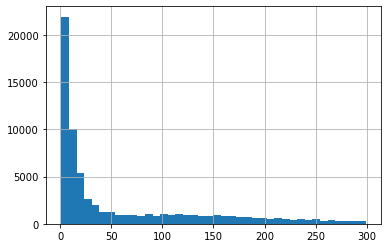

In [27]:
neutral_sentiment_df['word_count'].hist(bins=40)

Для балансировки можно сгруппировать по количеству слов диапазонами по 5 и взять из каждой группы по одинаковому количеству записей для каждого класса

### Для ускорения процесса искусственно ограничимся примерами до 100 слов

In [28]:
max_word_count = 100
step = 5
max_word_count_rounded = max_word_count - max_word_count % step

In [29]:
total_df = total_df[total_df['word_count'] < max_word_count_rounded]
total_df['wc_group'] = total_df['word_count'].apply(lambda x: int(x / step))
total_df.describe()

,sentiment,word_count,wc_group
count,146573.000000,146573.000000,146573.000000
mean,0.129731,25.381660,4.670615
std,0.801006,26.958083,5.397209
min,-1.000000,1.000000,0.000000
25%,-1.000000,6.000000,1.000000
50%,0.000000,13.000000,2.000000
75%,1.000000,35.000000,7.000000
max,1.000000,99.000000,19.000000


In [30]:
total_df.corr()

,sentiment,word_count,wc_group
sentiment,1.000000,0.158670,0.157981
word_count,0.158670,1.000000,0.998664
wc_group,0.157981,0.998664,1.000000


In [31]:
positive_sentiment_df = total_df[total_df['sentiment'] ==  1]
neutral_sentiment_df =  total_df[total_df['sentiment'] ==  0]
negative_sentiment_df = total_df[total_df['sentiment'] == -1]

In [32]:
positive_stats = positive_sentiment_df['wc_group'].value_counts(sort=False).to_frame()
neutral_stats = neutral_sentiment_df['wc_group'].value_counts(sort=False).to_frame()
negative_stats = negative_sentiment_df['wc_group'].value_counts(sort=False).to_frame()

stats = [positive_stats, neutral_stats, negative_stats]
stats_df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), stats)
stats_df.columns = ['positive', 'neutral', 'negative']

stats_df

,positive,neutral,negative
0,8137,10942,3801
1,11064,12873,10023
2,7118,7145,7086
3,4438,4173,4281
4,2880,2634,2731
5,2044,1846,1892
6,1605,1440,1373
7,1425,1078,1040
8,1346,880,797
9,1233,795,694


## Выводы и ограничения
Для равномерности распределения по классам и длительности текста необходимо из каждой группы от 0 (1-5 слов) по 19 (95-100 слов) брать по одинаковому количеству примеров

In [33]:
dfs = [positive_sentiment_df, neutral_sentiment_df, negative_sentiment_df]

result_dfs = []
for df in dfs:
    restricted_df = df[df['word_count'] < max_word_count]
    for name, group in restricted_df.groupby('wc_group'):
        n_samples = stats_df.loc[int(name)].min()        
        sampled_df = group.sample(n=n_samples)
        
        result_dfs.append(sampled_df)
        
balanced_df = reduce(lambda left, right: left.append(right), result_dfs)
balanced_df.head()

,text,sentiment,word_count,preprocessed,wc_group
19810,Герои детства!,1.0,2,герои детства,0
15238,ШиКаРна БаБа=»»,1.0,2,шикарна баба,0
68559,Всё отлично.супер платье.советую,1.0,4,отлично супер платье советую,0
1980,хочу дождь!!!,1.0,2,хочу дождь,0
78819,"пришло быстро, норм",1.0,3,пришло быстро норм,0


In [34]:
balanced_df.describe()

,sentiment,word_count,wc_group
count,115488.0000,115488.000000,115488.000000
mean,0.0000,22.343992,4.076553
std,0.8165,23.024631,4.602538
min,-1.0000,1.000000,0.000000
25%,-1.0000,7.000000,1.000000
50%,0.0000,13.000000,2.000000
75%,1.0000,27.000000,5.000000
max,1.0000,99.000000,19.000000


In [35]:
balanced_df.corr()

,sentiment,word_count,wc_group
sentiment,1.000000e+00,-0.000613,1.025710e-17
word_count,-6.125896e-04,1.000000,9.981473e-01
wc_group,1.025710e-17,0.998147,1.000000e+00


### Выводы
В полученном датасете равное распределение примеров для каждого класса, для разных длин входных данных; явных ошибочных корреляций не наблюдается.

## Лемматизация финального набора данных

In [36]:
import spacy
nlp = spacy.load('ru_core_news_sm')

In [37]:
balanced_df['preprocessed'] = balanced_df['preprocessed'].progress_apply(lambda row: ' '.join([w.lemma_ for w in nlp(row)]))

100%|██████████| 115488/115488 [25:37<00:00, 75.11it/s] 


In [38]:
balanced_df.head()

,text,sentiment,word_count,preprocessed,wc_group
19810,Герои детства!,1.0,2,герой детство,0
15238,ШиКаРна БаБа=»»,1.0,2,шикарный баба,0
68559,Всё отлично.супер платье.советую,1.0,4,отлично супер платье советую,0
1980,хочу дождь!!!,1.0,2,хотеть дождь,0
78819,"пришло быстро, норм",1.0,3,прийти быстро норма,0


In [40]:
balanced_df['word_count'] = balanced_df['preprocessed'].progress_apply(lambda x: len([word for word in x.split(' ')]))
balanced_df = balanced_df[balanced_df['word_count'] <= max_word_count]
balanced_df.to_csv('preprocessed.csv')

100%|██████████| 115488/115488 [00:00<00:00, 285149.36it/s]


In [41]:
balanced_df = pd.read_csv('preprocessed.csv')

# Подготовка данных для нейронной сети

In [42]:
from tqdm import tnrange, tqdm_notebook

Для анализа эмоционального окраса (sentiment analysis) для ускорения процесса обучения сети можно применить претренированный слой эмбеддингов (embeddings layer).
В данном случае принимаю решение использовать эмбеддинги "подслов" (subwords) от BPEmb (ru.wiki.bpe.vs100000.d100.w2v).

Использование "подслов" серьезно сокращает вероятность встретить незнакомые (out-of-vocabulary) слова, плюс ограниченный набор упрощает дотренировку слоя эмбеддингов (fine-tuning).

In [43]:
from bpemb import BPEmb
from pathlib import Path
bpemb = BPEmb(lang='ru', cache_dir=Path('./'), dim=100, vs=100000)

In [45]:
import mmap
import re

embeddings_path = 'ru/ru.wiki.bpe.vs100000.d100.w2v.txt'

def get_num_lines(file_path):
    fp = open(file_path, "r+")
    buf = mmap.mmap(fp.fileno(), 0)
    lines = 0
    while buf.readline():
        lines += 1
    return lines

embeddings_dict = {}
with open(embeddings_path, 'r', encoding='utf-8') as file:
    for line in tqdm_notebook(file, total=get_num_lines(embeddings_path)):
        values = line.split()
        word = values[0].lower()
        if word in embeddings_dict:
            continue
        
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_dict[word] = vector

D:\SoftwareProjects\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


Наведение порядка:

In [46]:
df = balanced_df[balanced_df['preprocessed'].notnull()]
df['sentiment']=df['sentiment'].astype('int32')
df.head()

,Unnamed: 0,text,sentiment,word_count,preprocessed,wc_group
0,19810,Герои детства!,1,2,герой детство,0
1,15238,ШиКаРна БаБа=»»,1,2,шикарный баба,0
2,68559,Всё отлично.супер платье.советую,1,4,отлично супер платье советую,0
3,1980,хочу дождь!!!,1,2,хотеть дождь,0
4,78819,"пришло быстро, норм",1,3,прийти быстро норма,0


## Обработка последовательностей

In [47]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(len(embeddings_dict.keys()))
tokenizer.fit_on_texts(tqdm_notebook(embeddings_dict.keys()))

df['sequences'] = df['preprocessed'].progress_apply(lambda x: tokenizer.texts_to_sequences([bpemb.encode(x)])[0])
df['seq_length'] = df['sequences'].progress_apply(lambda x: len(x))

max_sequence_length = df['seq_length'].max()
df['padded_sequences'] = df['sequences'].progress_apply(lambda x: pad_sequences([x], max_sequence_length)[0])

D:\SoftwareProjects\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  3%|▎         | 3997/115488 [00:00<00:02, 39573.95it/s]

100%|██████████| 115488/115488 [00:02<00:00, 47467.15it/s]


Если в слое эмбеддингов нет слов, использованных в тексте, колонка 'sequences' будет пустой. Исключим такие примеры из набора данных.

In [49]:
df = df[df['seq_length'] > 0]

Для слоя эмбеддингов не потребуется категоризация, но для лейблов она необходима (note: если не использовать sparse_categorical_loss).

In [52]:
allowed_outputs = list(df['sentiment'].unique())
outputs_index = {x:i for i, x in enumerate(allowed_outputs)}
print(outputs_index)

from tensorflow.keras.utils import to_categorical

df[f'output'] = df[f'sentiment'].apply(lambda x: outputs_index[x]) 
df[f'output'] = df[f'output'].apply(lambda x: to_categorical(x, num_classes=len(outputs_index)))   

{1: 0, 0: 1, -1: 2}


In [54]:
clean_df = df[['text', 'sentiment', 'preprocessed', 'sequences', 'seq_length', 'padded_sequences', 'output']]

In [56]:
clean_df.head()

,text,sentiment,preprocessed,sequences,seq_length,padded_sequences,output
0,Герои детства!,1,герой детство,"[2498, 18198]",2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.0, 0.0]"
1,ШиКаРна БаБа=»»,1,шикарный баба,"[87598, 252, 18093]",3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.0, 0.0]"
2,Всё отлично.супер платье.советую,1,отлично супер платье советую,"[26931, 4248, 28121, 3130, 5051]",5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.0, 0.0]"
3,хочу дождь!!!,1,хотеть дождь,"[17312, 190, 26222]",3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.0, 0.0]"
4,"пришло быстро, норм",1,прийти быстро норма,"[29505, 3837, 4998]",3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.0, 0.0]"


In [55]:
clean_df.to_csv('postprocessed.csv')

In [57]:
df = clean_df

## Подготовка тренировочного, валидационного и тестового наборов данных
Для упрощения анализа возможных ошибок также сбалансирую классы для этих подсетов.

In [60]:
from functools import reduce

positive_sentiment_df = df[df['sentiment'] == 1]
neutral_sentiment_df = df[df['sentiment'] == 0]
negative_sentiment_df = df[df['sentiment'] == -1]

def split_dataframe(dataframe):
    test = dataframe.sample(n=1000)
    validation = dataframe.loc[~dataframe.index.isin(test.index)].sample(n=3000)
    train = dataframe.loc[(~dataframe.index.isin(validation.index)) & (~dataframe.index.isin(test.index))].sample(frac=1)
    
    return (train, validation, test)

positive_split = split_dataframe(positive_sentiment_df)
neutral_split = split_dataframe(neutral_sentiment_df)
negative_split = split_dataframe(negative_sentiment_df)

train = positive_split[0].append(neutral_split[0]).append(negative_split[0])
validation = positive_split[1].append(neutral_split[1]).append(negative_split[1])
test = positive_split[2].append(neutral_split[2]).append(negative_split[2])

In [61]:
def get_arrayed_data(df_set):
    setX = np.stack(df_set['padded_sequences'].values, axis=0)
    setY = np.stack(df_set['output'].values, axis=0)
        
    return (setX, setY)

trainX, trainY = get_arrayed_data(train)
validationX, validationY = get_arrayed_data(validation)
testX, testY = get_arrayed_data(test)


print(trainX.shape, trainY.shape)
print(validationX.shape, validationY.shape)
print(testX.shape, testY.shape)

(103488, 188) (103488, 3)
(9000, 188) (9000, 3)
(3000, 188) (3000, 3)


Сохраняю некоторые данные, необходимые для дальнейшего standalone функционирования нейросети.

In [62]:
import json

with open('model/input-map.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer.word_index, ensure_ascii=False))
    
with open('model/input-sequence-length.txt', 'w', encoding='utf-8') as f:
    f.write(json.dumps(int(max_sequence_length), ensure_ascii=False))
    
one_hot_map = {int(v): int(k) for k, v in outputs_index.items()}
with open('model/output-map.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(one_hot_map, ensure_ascii=False))

# Построение нейронной сети

In [63]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history, title=''):
    colors = ['r', 'g', 'b', 'k']
    metrics= ['f1', 'precision', 'recall', 'acc']
    
    x = range(1, len(history['acc']) + 1)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.ylim(0, 1.1)
    for i, name in enumerate(metrics):
        plt.plot(x, history[name], colors[i], label=name) 
    plt.title(f'Training {title}')
    plt.legend()
        
    plt.subplot(1, 2, 2)
    plt.ylim(0, 1.1)
    for i, name in enumerate(metrics):
        name = f'val_{name}'
        plt.plot(x, history[name], colors[i], label=name)
    plt.title(f'Validation {title}')
    plt.legend()

In [64]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers

In [65]:
token_count = len(tokenizer.word_index) + 1
token_count

98740

In [66]:
from tensorflow.keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_value = true_positives / (possible_positives + K.epsilon())
    return recall_value

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_value = true_positives / (predicted_positives + K.epsilon())
    return precision_value

def f1(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    return 2*((precision_value*recall_value)/(precision_value+recall_value+K.epsilon()))

#### Эмпирическим путем было определено, что без fine-tuning'а слоя эмбеддингов не обойтись

In [73]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tqdm_notebook(tokenizer.word_index.items()):
    if word in embeddings_dict:
        embedding_matrix[i] = embeddings_dict[word]
        
embedding_layer = Embedding(len(tokenizer.word_index) + 1, 100,
                    weights=[embedding_matrix],
                    input_length=max_sequence_length,
                    embeddings_regularizer=regularizers.l2(0.001),
                    trainable=True)

D:\SoftwareProjects\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [77]:
inp = Input((max_sequence_length,))
x = embedding_layer(inp)
x = BatchNormalization()(x)

x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu',
           kernel_regularizer=regularizers.l1(0.001),
           bias_regularizer=regularizers.l1(0.001))(x)
x = BatchNormalization()(x)
x = AveragePooling1D(pool_size=2)(x)
x = Dropout(0.1)(x)

x = LSTM(64, activity_regularizer=regularizers.l1(0.0001))(x)
x = BatchNormalization()(x)

out = Dense(trainY.shape[1], activation='softmax')(x)
model = Model(inp, out)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', f1, precision, recall])

In [78]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 188)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 188, 100)          9874000   
_________________________________________________________________
batch_normalization_11 (Batc (None, 188, 100)          400       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 188, 64)           19264     
_________________________________________________________________
batch_normalization_12 (Batc (None, 188, 64)           256       
_________________________________________________________________
average_pooling1d_4 (Average (None, 94, 64)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 94, 64)            0   

In [79]:
save_best = ModelCheckpoint('model/best_weights_val_f1.hdf5', save_best_only=True, monitor='val_f1', mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_f1', mode='min', factor=0.2, patience=5, verbose=1, cooldown=3)

history = model.fit(trainX, trainY, batch_size=64, validation_data=(validationX, validationY), callbacks=[save_best, reduce_lr], epochs=50, verbose=1)

Train on 103488 samples, validate on 9000 samples
Epoch 1/50


D:\SoftwareProjects\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
D:\SoftwareProjects\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


103488/103488 [==============================] - 105s 1ms/sample - loss: 1500.6793 - acc: 0.6330 - f1: 0.6084 - precision: 0.6765 - recall: 0.5538 - val_loss: 997.1182 - val_acc: 0.6313 - val_f1: 0.6126 - val_precision: 0.6577 - val_recall: 0.5745
Epoch 2/50
103488/103488 [==============================] - 104s 1ms/sample - loss: 960.0840 - acc: 0.6841 - f1: 0.6661 - precision: 0.7210 - recall: 0.6198 - val_loss: 938.1407 - val_acc: 0.6836 - val_f1: 0.6693 - val_precision: 0.7190 - val_recall: 0.6270
Epoch 3/50
103488/103488 [==============================] - 104s 1ms/sample - loss: 922.2608 - acc: 0.7025 - f1: 0.6890 - precision: 0.7351 - recall: 0.6491 - val_loss: 906.7533 - val_acc: 0.6992 - val_f1: 0.6903 - val_precision: 0.7211 - val_recall: 0.66244 - precisio
Epoch 4/50
103488/103488 [==============================] - 102s 989us/sample - loss: 891.5760 - acc: 0.7150 - f1: 0.7039 - precision: 0.7442 - recall: 0.6683 - val_loss: 876.4583 - val_acc: 0.7004 - val_f1: 0.6920 - val_pre

KeyboardInterrupt: 

In [ ]:
plot_history(history.history)

In [81]:
model.load_weights('model/best_weights_val_f1.hdf5')
model.evaluate(testX, testY)

3000/3000 [==============================] - 3s 882us/sample - loss: 811.5924 - acc: 0.7197 - f1: 0.7111 - precision: 0.7323 - recall: 0.6918


[811.5923805338541, 0.71966666, 0.7111235, 0.7323402, 0.6918218]

## Исследуем ошибки:

In [82]:
validation_explorations = validation[['text', 'preprocessed', 'sentiment', 'sequences', 'padded_sequences']]
validation_explorations.head()

,text,preprocessed,sentiment,sequences,padded_sequences
36789,Первое впечатление после просмотра фильма было...,первый впечатление просмотр фильм очень двояки...,1,"[1282, 16120, 31807, 1821, 1841, 1445, 98686, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
31478,"платье очень хорошее, ткань качественная, плот...",платье очень хороший ткань качественный плотны...,1,"[28121, 1841, 23365, 29161, 72556, 65635, 9388...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
20491,"Джинсы класс , заказала на свой обычный s , та...",джинсы класс заказать свой обычный сесть прям ...,1,"[19278, 646, 7431, 75309, 1706, 24235, 61828, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8083,Джинсы супер! Беру уже во второй раз.,джинсы супер брать второй раз,1,"[19278, 646, 4248, 23976, 1252, 279]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
29650,"Отличная юбка , оригинально сделанная, не прос...",отличный юбка оригинально сделать не просвечив...,1,"[49112, 386, 6911, 4050, 872, 5688, 173, 7413,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [83]:
import operator

def predict(ps):
    padded_sequense_array = np.reshape(ps, (1, max_sequence_length))
    vector = model.predict(padded_sequense_array).T
    vector = np.concatenate(vector, axis=0 )
    zipped = np.array(list(zip(outputs_index.keys(), vector.T)))
    answer = {x[0]:x[1] for x in zipped}
    answer = sorted(answer.items(), key=lambda x: float(operator.itemgetter(1)(x)), reverse=True)[:10]
    pred_sentiment = answer[0][0]
    return int(pred_sentiment)

In [84]:
validation_explorations['pred_sentiment'] = validation_explorations['padded_sequences'].progress_apply(predict)
validation_explorations.head()

100%|██████████| 9000/9000 [05:04<00:00, 29.51it/s]
D:\SoftwareProjects\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,text,preprocessed,sentiment,sequences,padded_sequences,pred_sentiment
36789,Первое впечатление после просмотра фильма было...,первый впечатление просмотр фильм очень двояки...,1,"[1282, 16120, 31807, 1821, 1841, 1445, 98686, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
31478,"платье очень хорошее, ткань качественная, плот...",платье очень хороший ткань качественный плотны...,1,"[28121, 1841, 23365, 29161, 72556, 65635, 9388...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
20491,"Джинсы класс , заказала на свой обычный s , та...",джинсы класс заказать свой обычный сесть прям ...,1,"[19278, 646, 7431, 75309, 1706, 24235, 61828, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
8083,Джинсы супер! Беру уже во второй раз.,джинсы супер брать второй раз,1,"[19278, 646, 4248, 23976, 1252, 279]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
29650,"Отличная юбка , оригинально сделанная, не прос...",отличный юбка оригинально сделать не просвечив...,1,"[49112, 386, 6911, 4050, 872, 5688, 173, 7413,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


In [85]:
validation_explorations_fails = validation_explorations[validation_explorations['pred_sentiment'] != validation_explorations['sentiment']]
validation_explorations_fails.describe()

,sentiment,pred_sentiment
count,2625.000000,2625.000000
mean,-0.108571,-0.110095
std,0.722582,0.738009
min,-1.000000,-1.000000
25%,-1.000000,-1.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [86]:
import itertools

#для демонстрации ограничимся 50 примерами - в реальном проекте необходимо анализировать больше ошибок
for i, row in itertools.islice(validation_explorations_fails.iterrows(), 50):
    print('text: ', row['text'])
    print('preprocessed text: ', row['preprocessed'])
    print('sequenced text: ', tokenizer.sequences_to_texts([row['sequences']]))
    print(f'predicted: {(row["pred_sentiment"])}, true label: {(row["sentiment"])}')
    print()
    print()

text:  Первое впечатление после просмотра фильма было очень двояким. Долгое время я не мог понять, понравился он мне или нет. Как не странно, но чувство аморальности у меня после него не появилось, несмотря на мою достаточно высокую нравственность. Фильм так снят, что появляется ощущение, будто бы это вполне нормально. Лучше стараться смотреть это детище глазами ребёнка или тех неполноценных людей, что его окружают. Ведь каждый из них живет в собственном мире, достаточно далеким от реального, и для них все вокруг - лишь поле для игры.  Назвать этот фильм плохим или хорошим я так и не смогу. В фильме хорошая режиссура, хорошая игра актёров, удивительные пейзажи... Но оценка самой идеи и сюжета фильма остается на индивидуальный вкус каждого. Постарайтесь отбросить все предубеждения и посмотреть на этот фильм невинным детским взглядом.
preprocessed text:  первый впечатление просмотр фильм очень двоякий долгий время не мочь понять понравиться нет не странный чувство аморальность не появить

In [87]:
def get_fail_group(row):
    return f"({row['sentiment']})-({row['pred_sentiment']})"

validation_explorations_fails['fail_group'] = validation_explorations_fails.progress_apply(get_fail_group, axis=1)

100%|██████████| 2625/2625 [00:00<00:00, 62485.73it/s]
D:\SoftwareProjects\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<AxesSubplot:>

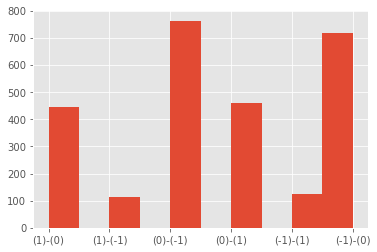

In [88]:
validation_explorations_fails['fail_group'].hist()

array([<AxesSubplot:title={'center':'sentiment'}>], dtype=object)

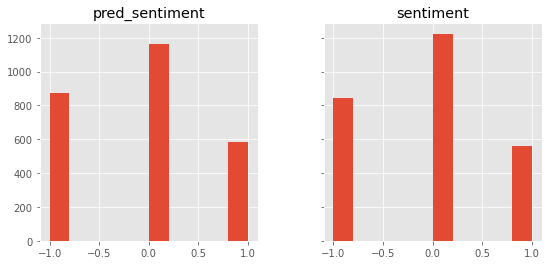

In [107]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(9, 4))
validation_explorations_fails.hist(column='pred_sentiment', ax=ax[0])
validation_explorations_fails.hist(column='sentiment', ax=ax[1])

In [91]:
import sklearn.metrics as skm
testY_pred = model.predict(testX)
testY_pred = np.argmax(testY_pred, axis=1)
testY_pred = np.apply_along_axis(lambda x: to_categorical(x, num_classes=len(outputs_index)), 0, testY_pred)

print(skm.classification_report(testY, testY_pred, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.80      0.80      0.80      1000
     neutral       0.62      0.61      0.61      1000
    negative       0.74      0.74      0.74      1000

   micro avg       0.72      0.72      0.72      3000
   macro avg       0.72      0.72      0.72      3000
weighted avg       0.72      0.72      0.72      3000
 samples avg       0.72      0.72      0.72      3000



# Выводы и комментарии

Нейросеть редко допускает грубые ошибки, когда истинный лейбл является прямопротивоположным предсказанному.
Частая ошибка нейросети заключается в присваивании нейтральных лейблов.

Некоторые мысли насчет улучшения качества сети:
* Система может показать лучший результат, если использовать ансамбль из нескольких нейронный сетей, натренированных на работу с текстами определенной длины, например, до 20 слов, до 50 слов и до 100 слов.
* В реальных сообщениях человек может иронично назвать непонравившийся фильм "шедевром" в кавычках - возможно не стоит избавляться от всех символов.
* Имеет смысл сети оставлять запятые, чтобы было понятно, к чему относится то или прилагательное.
* Т.к. сеть имеет некоторый перекос в ошибках с нейтральными примерами, имеет смысл немного перебалансировать обучающий набор

# K-fold валидация

Финальная проверка - доказательство того, что точность модели не привязана к подобранным данным.
В настоящем примере в силу ограниченностиы вычислительных возможностей не провожу.

# Экспорт модели

In [108]:
model_json = model.to_json()
with open("model/model-config.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("model/model-weights.h5")